## Hand-written digit classification using nearest subspace  
2017-10-20 Jeff Fessler, University of Michigan  
2018-10-09 Julia 1.0.1 with Steven Whitaker  
2020-10-04 Julia 1.5.0 and added commentary - Caroline Crockett <br>
2021-10-01 Julia 1.6.0 and added commentary - Zongyu Li

## Group Formation and General Instructions
You may work individually, but we recommend that you work in pairs or groups of three. Find someone to work with and introduce yourself to them! One of you should copy the Google Document template and share the document with edit permissions with your group member(s): 
https://docs.google.com/document/d/1xHXktd0jroUftZ1jX9QJgxJjvyDTGnFJwLhfvZosDJc/template/preview (you must use your umich email address to access this google document). 

The Google Document will include your answers to a couple of questions that will be asked. For each question, pick someone to type up your **group's** response. After completing the response, the group member should sign their name by typing it below the answer. For the next question, have a different group member respond and sign their name in the same way. Keep rotating until all the questions have been answered.

The goal of this group exercise is to formulate your response as a group to the problem. When finished, **one** student in the group must submit a PDF of the google document to gradescope, entering the uniquenames of **all** students in the group. One group submits exactly one PDF, but we expect the PDF from different groups to differ. The deadline for submitting to gradescope will be announced on Canvas. Only submit the filled-in google document; do not submit a download of this Jupyter notebook. 

### Overview
This notebook illustrates how to classify handwritten digits
using a nearest-subspace approach.
We focus initially on just a pair of digits,
although later you will generalize to all digits. 

In [2]:
# packages needed
using Plots
using LinearAlgebra # svd, norm, etc.
using Statistics: mean
using MIRTjim: jim
using MLDatasets 

In [2]:
import Pkg; Pkg.add("MLDatasets")

    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
   Installed Lz4_jll ───────── v1.9.3+0
   Installed URIParser ─────── v0.4.1
   Installed Blosc ─────────── v0.7.0
   Installed GZip ──────────── v0.5.1
   Installed BinDeps ───────── v1.0.2
   Installed PyCall ────────── v1.92.3
   Installed MLDatasets ────── v0.5.11
   Installed DataDeps ──────── v0.7.7
   Installed HDF5_jll ──────── v1.12.0+1
   Installed Blosc_jll ─────── v1.21.0+0
   Installed BufferedStreams ─ v1.0.0
   Installed BinaryProvider ── v0.5.10
   Installed HDF5 ──────────── v0.15.6
   Installed MAT ───────────── v0.10.1
    Updating `~/.julia/environments/v1.6/Project.toml`
  [eb30cadb] + MLDatasets v0.5.11
    Updating `~/.julia/environments/v1.6/Manifest.toml`
  [9e28174c] + BinDeps v1.0.2
  [b99e7846] + BinaryProvider v0.5.10
  [a74b3585] + Blosc v0.7.0
  [e1450e63] + BufferedStreams v1.0.0
  [124859b0] + DataDeps v0.7.7
  [92fee26a] + GZip v0.5.1
  [f67ccb44] + HDF5 v0.15.6
  

### Part 0: load the data and look at it  
This time we are going to work with the 4 and 9 digits
because those are harder to separate.

In [3]:
# read the MNIST data file for 4 and 9 digits
# download from web if needed
if !@isdefined(data)
    digitn = [4, 9]
    tmpx, tmpy = MNIST.traindata(Float32)
    data = n -> tmpx[:,:,findall(tmpy .== n)[1:1000]] # 1st 1000 of digit n
    data = 255 * cat(dims=4, data.(digitn)...)
    nx, ny, nrep, ndigit = size(data)
    data = data[:,2:ny,:,:] # make images non-square to force debug
    ny = size(data,2)
    @show size(data)
end
d0 = data[:,:,:,1]
d1 = data[:,:,:,2]

# Convert images to Float32 to avoid overflow errors
d0 = Array{Float32}(d0)
d1 = Array{Float32}(d1)

@show size(d0);

size(data) = (28, 27, 1000, 2)
size(d0) = (28, 27, 1000)


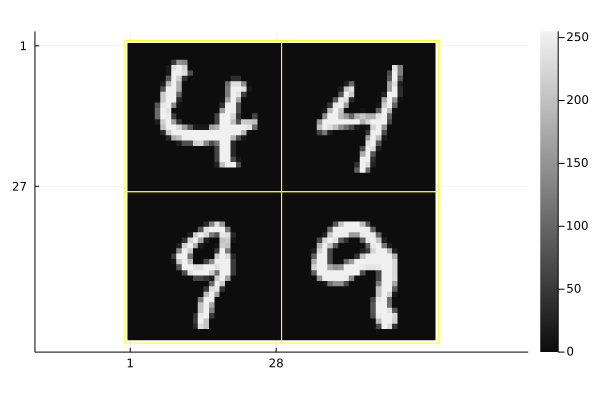

In [54]:
# look at a couple of the images
jim(cat(d0[:,:,44:45], d1[:,:,654:655], dims=3))

In [4]:
# use some data for training, and some for test
ntrain = 100
ntest = nrep - ntrain
train0 = d0[:,:,1:ntrain] # training data
train1 = d1[:,:,1:ntrain]
test0 = d0[:,:,(ntrain+1):end] # testing data
test1 = d1[:,:,(ntrain+1):end];


size(mean0) = (28, 27, 1)


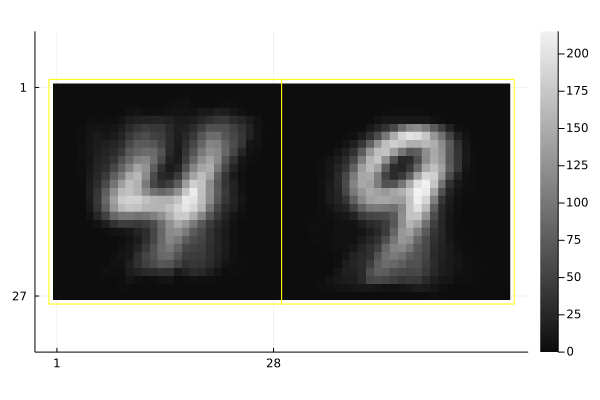

In [56]:
# look at mean image from each class just to get a sense of things
mean0 = mean(train0, dims=3) # makes a 3D array 28x27x1
mean1 = mean(train1, dims=3)
@show size(mean0)
jim(cat(mean0, mean1, dims=3))

### Part 1: Scree plot
First, you will plot the singular values for both digits' training data on the same graph. 
This is called a "scree plot" - it can be helpful for choosing a dimension/rank.
We typically choose the rank at the "knee" in the plot - where the curve flattens outs. 

This is one exmample of why 551 is an engineering (not math) course. 
There is no single "correct" answer for where the knee in a scree plot is or how many singular vectors you should use to form your subspace. 
In practice, this is a judgement call and something that you can get better at with practice. 

For this part, you will turn in your scree plot and an explanation of where you think the knee is in your scree plot.

Hints: 
- you probably will need to call ```reshape``` here. Just like task 1, we are considering each image as a "vector" 

In [5]:
train0r = reshape(train0, :, ntrain) # reshape the data so that each column is a vector with the data form one image 
train1r = reshape(train1, :, ntrain)
test0r = reshape(test0, :, ntest)
test1r = reshape(test1, :, ntest)


756×900 Matrix{Float32}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [6]:
size(train0r)

(756, 100)

In [58]:
# TODO: find the singular values and singular vectors for the training data 

# name your left singular vectors u0 and u1 and your singular values s0 and s1
# so that subsequent plot commands will work

# YOUR CODE HERE 
u0, s0, _ =  svd(train0r)
u1, s1, _ = svd(train1r)

SVD{Float32, Float32, Matrix{Float32}}
U factor:
756×100 Matrix{Float32}:
 -6.58475f-8   -1.05601f-9    1.08953f-8  …  -2.16556f-8   -7.65557f-8
  8.91659f-9   -2.16749f-8    1.20861f-8     -2.61559f-7   -5.95239f-8
 -7.53175f-9    1.85422f-9   -1.93491f-8      3.0152f-8     1.7421f-7
 -1.64522f-8    1.68641f-8   -2.32258f-8     -1.58556f-8   -4.85099f-8
 -1.24985f-8    7.19188f-9    5.72767f-8      8.31221f-8    1.80072f-7
  9.29067f-9    2.54888f-9    2.50273f-9  …   1.22353f-7   -8.15955f-9
 -8.69602f-9   -1.43545f-8   -9.42059f-9     -4.01357f-8   -6.69414f-8
 -3.90339f-9   -3.56636f-9   -7.4437f-10     -2.19189f-8   -1.1777f-8
 -7.48776f-9    5.70622f-9   -2.04182f-8      1.39183f-7   -9.80061f-8
  1.67144f-9    8.31222f-10   1.21855f-8     -7.21515f-8    1.24022f-8
 -3.175f-9     -2.89369f-9   -1.60205f-8  …  -1.22379f-7   -4.0433f-8
  5.62143f-9    1.37225f-8    2.04121f-9      6.80976f-8    9.98136f-8
  7.83944f-9    5.8999f-9    -2.17688f-9      3.37377f-8   -2.15802f-8
  ⋮   

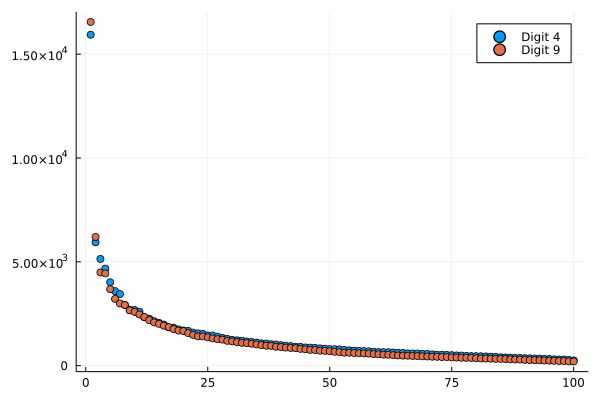

In [88]:
# Make a scree plot: include this plot in your write-up 
# along with an explanation of where you think the knee is 
plot(1:ntrain, s0, line=(:dots, :blue), label="Digit 4")
plot!(1:ntrain, s1, line=(:dots, :red), label="Digit 9")

In [89]:
savefig("task3_part1_scree.png")

### Part 2: Look at the subspace basis vectors 

For this task, we will use 3 left singular vectors as the basis for our subspaces (for consistency and ease of grading). 
Next, you will display these first three left singular vectors of the training data for each digit. 
These are essentially very similar to the "principle components" in principle component analysis (PCA),
but keep in mind PCA is operated on "centered" data matrix, i.e., $(X-\mu)(X-\mu)'$, where $X$ is a $d \times n$ matrix,
$\mu = \frac{1}{n}\sum_{i=1}^n X_i$, $d$ is the dimension of features, $n$ is the number of data points. The subtraction $X-\mu$ is operated in column-wise.

Here in this task,
the idea behind the subspace classifier is
that to build a classifier that works on a lower dimensional subspace, i.e., defined by singular vectors.
In testing, for any given test vector, we first compute its projection onto
each subspace (# of subspaces = # of classes).
Then we choose the closest subspace (to that test vector)
and assign the corresponding label.
How to choose the closest subspace? 
Well, we need projection matrix (chapter 3).
For this part, you will turn in a plot of the first three left singular vectors for both digits and an explanation of whether the vectors look "sensible." 

In [44]:
q0

28×27×3 Array{Float32, 3}:
[:, :, 1] =
  3.65419f-8    1.23641f-9   -3.37338f-10  …   0.0           0.0          0.0
  1.07467f-8   -3.32025f-9    9.81189f-10      0.0           0.0          0.0
  1.54944f-8    1.11605f-9    9.16683f-10      0.0           0.0          0.0
 -1.07737f-8   -1.37697f-10  -3.01493f-10      0.0           0.0          0.0
 -3.94612f-9   -4.49115f-10   7.07864f-10      0.0           0.0          0.0
 -5.16261f-9    5.28433f-10  -2.20105f-10  …   0.0           0.0          0.0
 -1.30177f-8   -3.32084f-10   5.4727f-10      -5.14875f-5    0.0          0.0
  3.08313f-9   -9.29148f-10  -4.53917f-10      0.0           0.0          0.0
 -3.93506f-9    5.18989f-10   6.06343f-11     -0.00142027   -0.000613606  0.0
  3.02837f-9   -1.51009f-9   -2.77667f-10     -0.00460101   -0.000384386  0.0
 -3.05061f-9   -5.64384f-10   2.8248f-9    …  -0.00250379    0.0          0.0
  8.25655f-10  -5.71344f-10   5.13875f-10     -0.00120185    0.0          0.0
 -4.18713f-9   -1.13411f-

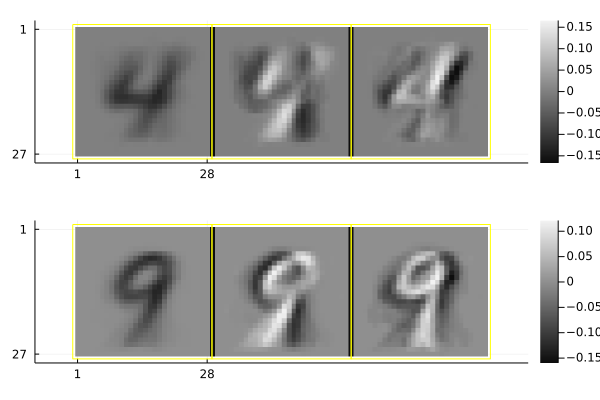

In [86]:
# TODO - complete this code
# We have given an example of how to show the images for the 4s
# You must also show the 9s 

r0, r1 = 3, 3 # make these variables so our code is more general! 
q0 = reshape(u0[:,1:r0], nx, ny, :)
q1 = reshape(u1[:,1:r1], nx, ny, :)

# show images of the 1st 3 components
p0 = jim(q0[:,:,1:3])
p1 = jim(q1[:,:,1:3])

# Combine both plots in a single output 
plot(p0, p1, layout=(2,1))

In [87]:
savefig("task3_part2_basis.png")

### Part 3: Explore how well the first left singular vectors separate the two classes  
Here we regress each of the training digits onto the first left singular vectors of the two classes, and then make a scatter plot to see how well separated they are.  
We will later use the first *3* left singular vectors to form our basis. We use only *1* in the code here just for easier visualization.

By "regress" we mean solve a linear LS problem of the form
$\hat{x} = \underset{x \in \mathbb{R}}{\arg \min} \lVert y - U x \rVert_2 = U'y$ (think about why), where: 
- $U \in \mathbb{R}^{27\cdot 28 \times 1}$ is the subspace basis (the first part of what you just visualized in the previous part)
- $y$ is a given training sample (think about its dimensions) 
- $x \in \mathbb{R}^1$ is a single linear coefficient 

You should see two clouds of points (these are projection coefficients, where the projection matrix is $UU'$) that are somewhat separated, but not perfectly so.
Include this plot in your report.
Also include an explanation of what the regress function returns. 
This plot illustrates that some high dimensional data are separable in lower dimension,
so we only need to build a classifier that works in lower dimension.

$\begin{align}
\hat{x} &= \underset{x \in \mathbb{R}}{\arg \min} \lVert y - U x \rVert_2
= \underset{x \in \mathbb{R}}{\arg \min} \lVert y - U x \rVert_2^2
\\
&= \underset{x \in \mathbb{R}}{\arg \min} (y'y - x'U'y - y'Ux + x'x) \quad \text{because } U'U=I
\\
&= \underset{x \in \mathbb{R}}{\arg \min} (y'UU'y - x'U'y - y'Ux + x'x) \quad \text{because }x \text{ is independent to }U \text{ and } y
\\
&= \underset{x \in \mathbb{R}}{\arg \min} \|x - U'y\|_2^2
=U'y.
\end{align}$

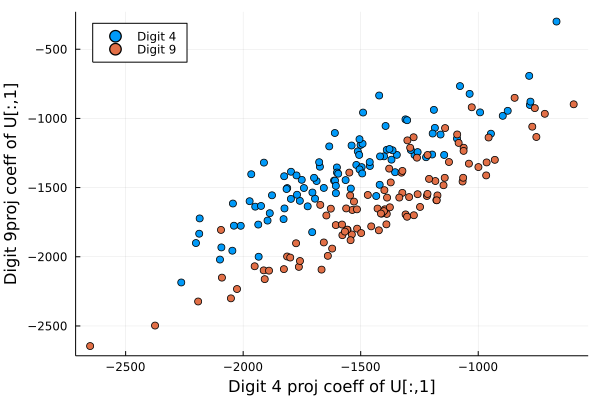

In [79]:
# think about what the question mark should be
regress = (data, u) -> vec(mapslices(y->dot(u,y), data, dims=(1,2)))
scatter(regress(train0, u0[:,1]), regress(train0, u1[:,1]), label="Digit 4")
scatter!(regress(train1, u0[:,1]), regress(train1, u1[:,1]), label="Digit 9")
plot!(xlabel = "Digit 4 " * "proj coeff of U[:,1]", ylabel = "Digit 9" * "proj coeff of U[:,1]", legend=:topleft)

In [80]:
savefig("task3_part3_scatter.png")

### Part 4: Classification based on nearest subspace  
This is the core of this project.  

You are going to take each test digit and project it onto the subspaces
defined by the first *three* left singular vectors
of each of the two digit's training data.
We will see in a later chapter why using a few of the left singular vectors is a reasonable choice of basis for a subspace in such applications.  

You will compute the distance of each test digit to those subspaces
and you will classify each digit by choosing the subspace that is closest.
Recall that if $Q_0$ is a matrix with orthonormal columns,
then the projection of a vector $y$ onto the subspace
Range($Q_0$) is simply
$\hat{y} = Q_0(Q_0'y)$,
and the distance between $y$ and that point is $|| \hat{y} - y ||_2$.  

Count how many of the test digits are classified correctly
and report the classification accuracy
for the 4's and the 9's in your report. 
Also comment on the classification accuracy in your report. 


Hints:
- The accuracies are roughly 80% and 90% (rounded to the nearest multiple of 10).
- Write what you are trying to solve in math before trying to code it
- ```reshape``` is again useful here.

In [77]:
Q0 = reshape(q0, nx*ny, r0)
Q1 = reshape(q1, nx*ny, r1)
y0 = reshape(test0, nx*ny, :)
@show size(Q0)
@show size(Q1)

size(Q0) = (756, 3)
size(Q1) = (756, 3)


(756, 3)

In [67]:
# TODO 
# Define variables y00, y01, y10, and y10 such that
# each variable is of size 28*27 x 900 (recall ntest=900)
# y01[:,i] corresponds to y-yhat for y=(the ith column of y0) when using Q1 as the basis
# y00[:,i] corresponds to y-yhat for y=(the ith column of y0) when using Q0 as the basis
# y11[:,i] corresponds to y-yhat for y=(the ith column of y1) when using Q1 as the basis
# y10[:,i] corresponds to y-yhat for y=(the ith column of y1) when using Q0 as the basis

# this can be done very efficiently (no for loops), 
# but you are welcome to use a for loop if you would like 
Q0 = reshape(q0, nx*ny, r0)
Q1 = reshape(q1, nx*ny, r1)

y0 = reshape(test0, nx*ny, :)
y00 = y0 - Q0*(Q0'*y0)
y01 = y0 - Q1*(Q1'*y0)

y1 = reshape(test1, nx*ny, :)
y10 = y1 - Q0*(Q0'*y1)
y11 = y1 - Q1*(Q1'*y1)

756×900 Matrix{Float32}:
 -0.000134418  -8.47883f-5  -0.000101947  …  -7.647f-5    -0.000123812
  3.51328f-5    2.31348f-5   3.92805f-5       1.52082f-5   1.45152f-5
 -2.677f-5     -6.70437f-6  -2.57963f-5      -1.70178f-5  -1.67803f-5
 -5.46682f-5   -2.71343f-5  -5.48172f-5      -2.91038f-5  -3.13978f-5
 -7.97307f-7   -3.25438f-5   8.54461f-6       8.02377f-6  -1.40237f-5
  1.99201f-5    9.5249f-6    1.49604f-5   …   1.24925f-5   1.85227f-5
 -1.67498f-5    5.12315f-7  -8.89454f-6      -1.4901f-5   -2.06871f-5
 -7.0662f-6    -2.40887f-6  -4.13145f-6      -5.19654f-6  -8.2208f-6
 -2.89906f-5   -8.98322f-6  -2.94116f-5      -1.72848f-5  -1.61062f-5
  9.38829f-6   -9.87117f-7   9.56542f-6       7.00363f-6   5.11453f-6
 -1.36005f-5    1.25834f-6  -1.27813f-5   …  -1.046f-5    -8.93161f-6
  6.72444f-6   -2.43541f-6  -2.24368f-7       8.12387f-6   1.36437f-5
  1.29019f-5    6.44397f-6   7.04978f-6       8.91527f-6   1.57307f-5
  ⋮                                       ⋱               
  0.0 

In [90]:
# if you defined y00, y01, y10, and y11 correctly, 
# then this code will compute the classification accuracy! 
correct0 = (mapslices(norm, y00, dims=1) .< mapslices(norm, y01, dims=1))[:]
@show round(sum(correct0) / ntest, digits=4)

correct1 = (mapslices(norm, y10, dims=1) .> mapslices(norm, y11, dims=1))[:]
@show round(sum(correct1) / ntest, digits=4);

round(sum(correct0) / ntest, digits = 4) = 0.7722
round(sum(correct1) / ntest, digits = 4) = 0.9311


### Part 5: Find all the misclassified digits and display a couple of them  
  
Show pictures of the first two 4's and 9's that are misclassified in your report.

length(bad0) = 205
length(bad1) = 62


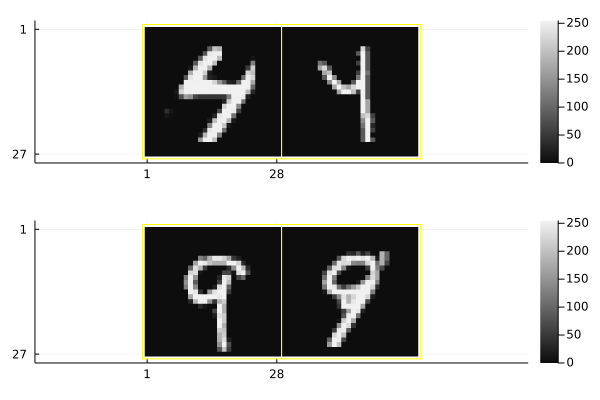

In [84]:
bad0 = findall(correct0 .== false)
bad1 = findall(correct1 .== false)
@show length(bad0)
@show length(bad1)
p0 = jim(test0[:,:,bad0[1:2]])
p1 = jim(test1[:,:,bad0[1:2]])
plot(p0,p1, layout=(2,1))

In [85]:
savefig("task3_part5_misclassified.png")

### Optional Tasks   
* Go back to the previous classifiers (nearest angle and LS with hand-crafted features) for the "4" and "9" digits and compare the classification accuracies of those methods with this nearest subspace method.

* Try other subspace dimensions instead of just 3 to see if you can improve accuracy by using fewer or more left singular vectors.

* Generalize to nearest-subspace classification of all 10 digits.
This is fairly easy to do and we'll probably have the whole class do it
in a future discussion section.  The key to making it efficient is to use a 4D array of data of size [28,27,ntest,10] instead of separate variables data0, data1, data2, ... like we have used in this notebook.